# Spam Message Classification using Deep Learning

Natural language processing (NLP) for classifying SMS-messages as spam or not spam, based on the SMS contents.

## Install the Required Libraries

In [46]:
!pip3 install -q --upgrade numpy==1.19.2 pandas==1.1.2 matplotlib==3.3.2 scikit-learn==0.23.2 keras==2.4.0

## Import Libraries

In [50]:
import numpy as np
import pandas as pd
import tensorflow as tf

from collections import Counter

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.models import Sequential
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

## Load the Dataset

In [7]:
sms_messages = pd.read_csv('../data/spam.csv', encoding='latin1')
sms_messages = sms_messages.iloc[:, [0, 1]]
sms_messages.columns = ["label", "message"]
sms_messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
sms_messages.shape

(5572, 2)

## Exploratory Data Analysis

### Label Count

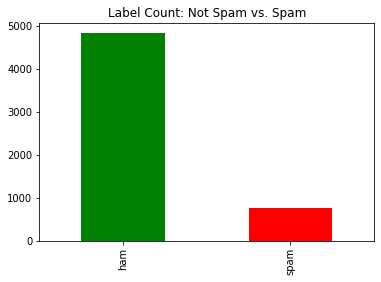

In [10]:
label_count = pd.value_counts(sms_messages["label"], sort=True)
label_count.plot(kind = "bar", color = ["green", "red"])
plt.title("Label Count: Not Spam vs. Spam")
plt.show()

### Message Uniqueness

In [11]:
sms_messages.groupby("label").describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

### Feature Engineering: Message Length

In [12]:
sms_messages["length"] = sms_messages["message"].apply(len)
sms_messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Compare Message Length by Label

Text(0.5, 0, 'Message Length')

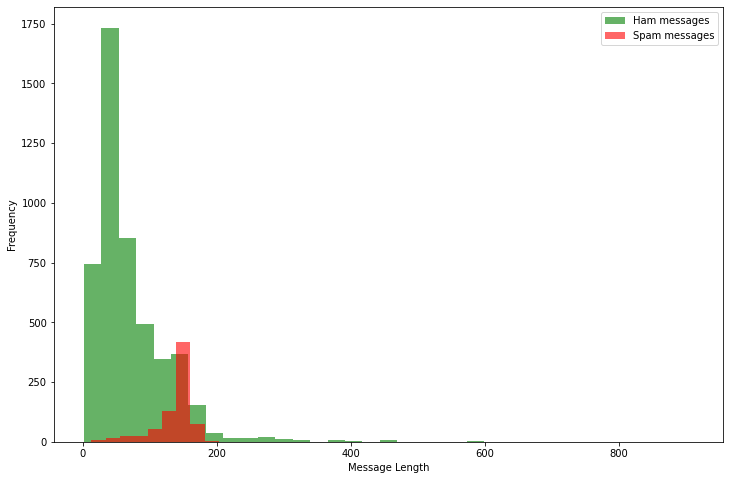

In [19]:
plt.figure(figsize=(12, 8))

sms_messages[sms_messages.label=="ham"].length.plot(
    bins=35, kind="hist", color="green", label="Ham messages", alpha=0.6)
sms_messages[sms_messages.label=="spam"].length.plot(
    kind="hist", color="red", label="Spam messages", alpha=0.6)

plt.legend()
plt.xlabel("Message Length")

### Most Common Words

In [36]:
common_ham = Counter(" ".join(sms_messages[sms_messages["label"] == "ham"]["message"]).split()).most_common(20)
df_common_ham = pd.DataFrame.from_dict(common_ham)
df_common_ham = df_common_ham.rename(columns={0: "Word", 1: "Count"})

common_spam = Counter(" ".join(sms_messages[sms_messages["label"] == "spam"]["message"]).split()).most_common(20)
df_common_spam = pd.DataFrame.from_dict(common_spam)
df_common_spam = df_common_spam.rename(columns={0: "Word", 1: "Count"})

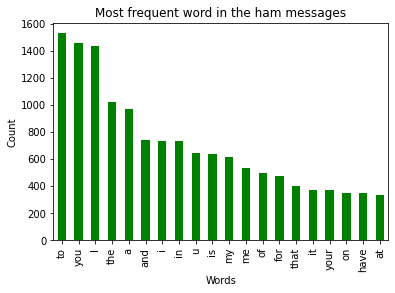

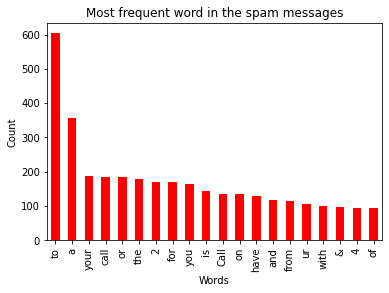

In [39]:
df_common_ham.plot.bar(legend = False, color = "green")
y_pos = np.arange(len(df_common_ham["Word"]))
plt.xticks(y_pos, df_common_ham["Word"])
plt.title("Most frequent word in the ham messages")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()

df_common_spam.plot.bar(legend = False, color = "red")
y_pos = np.arange(len(df_common_spam["Word"]))
plt.xticks(y_pos, df_common_spam["Word"])
plt.title("Most frequent word in the spam messages")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()

## Build the Model

### Preprocessing